# Part-2 Train the model

## Import third-party modules

In [1]:
import numpy as np
import shutil
import re
import numpy
import pandas as pd
import csv
import math
import string
import sys
import fileinput
import json
import urllib
import urllib3
import requests
import zipfile
import time
import argparse
import pickle
from termcolor import colored, cprint
import colorama
import webbrowser
import base64
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
import sklearn.ensemble as ske
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict, learning_curve,GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from first_part import URLFeatures,parse_url
from sklearn.ensemble import RandomForestClassifier

## Define functions for valuation of machine learning estimator

1. **get_learning_curve** is used for plotting the train_accuracy,valiadation_accuracy when number of training samples change

In [5]:
def get_learning_curve(X, y):
    clf=ske.RandomForestClassifier(max_features='log2', n_estimators=250)
    parameter_grid = np.array([1, 200, 400, 600, 800, 1500])
    train_size, train_scores, validation_scores = learning_curve(clf, X, y, train_sizes=parameter_grid, cv=5)
    
    # plot the data
    plt.figure(figsize=(12, 8), dpi = 300)
    plt.plot(parameter_grid, 100 * np.average(train_scores, axis=1), color='black',label='train accuracy')
    plt.plot(parameter_grid, 100 * np.average(validation_scores,axis=1),color='red',label='validation accuracy')
    plt.plot(parameter_grid,100*np.repeat((np.average(validation_scores,axis=1)[-1]+np.average(train_scores, axis=1)[-1])/2,6),
             color='blue',linestyle='--',label='desired accuracy')
    plt.legend(loc='lower right')
    plt.title('Learning curve')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.ylim([0, 110])

2. **plot_confusion_matrix** is used for plotting the confusion matrix

In [6]:
def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # Normalize
    plt.figure(figsize = (12, 8), dpi = 300)
    plt.imshow(cm, interpolation='nearest')    # Display images on specific windows
    plt.title(title)    # Title of the image
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))
    plt.xticks(num_local, labels_name, rotation=90)    
    plt.yticks(num_local, labels_name)    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

3. **plot_ROC_CURVE** is used for plotting the ROC CURVE 

In [7]:
def plot_ROC_CURVE(y,Y):
    # plot ROC curve
    fpr, tpr, threshold = roc_curve(y, Y)  # Calculate TPR and FPR
    roc_auc = auc(fpr, tpr)  # calculate ROC

    plt.figure(figsize = (12, 8), dpi = 300)
    lw = 2
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange',
             lw = lw, label='ROC curve (area = %0.2f)' % roc_auc)  # FPR as x，TPR as y
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

4. **plot_pca** is used for plotting the explanined variance of componets

In [8]:
##Plot the explaned variance of componet
def plot_pca(X):   
    cov_mat = np.cov(X.T)
    eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
    tot = sum(eigen_vals)
    var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    plt.figure(figsize = (12, 8), dpi = 300)
    plt.bar(range(1, 1+len(var_exp)), var_exp, alpha=0.5, align='center',label='individual explained variance')
    plt.step(range(1, 1+len(var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title('Explained variance of componets')

all above function will be  called in **train_model** function

## Main part: define the train_model function
- In this part, we will use Random Forest to train the model with data from part-I and visiualize the result with functions defined above
- Using joblib, we store our trained model in pkl file, so that we can call it from other py files.

1. **Load** data_urls.csv, which was generated by Part-1.ipynb.

In [9]:
df = pd.read_csv('data_urls.csv', sep='|')
df.head()

,URL,Entropy,BagOfWords,ContainsIP,LengthURL,SpecialChars,SuspiciousStrings,NumberOfDigits,Popularity,Malicious
0,www.businesspage.ecuaradionline.com/9feaf7f835...,4.603980,5,0,69,0,0,19,0,1
1,businesspage.ecuaradionline.com/,3.905639,3,0,32,0,0,0,0,1
2,www.lotto109.com/follow-up/eb6e30faeebb16feaf0...,4.229086,6,0,60,0,0,17,0,1
3,businesspage.ecuaradionline.com/b0028c28760971...,4.518543,4,0,65,0,0,25,0,1
4,businesspageshop.businesspage.ecuaradionline.c...,4.516677,5,0,82,0,0,18,0,1


2. **Extract** features and y-values into corresponding variables.

In [10]:
# Assigns X to features. Drops URL name and label.
X = df.drop(['URL', 'Malicious'], axis=1).values

# Assigns y to labels.
y = df['Malicious'].values

3.**Split data** into training and test datasets.

In [11]:
# Split data into training and test datasets.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42) 

# Print the number of training and testing samples.
print("Training samples: ", len(X_train))
print("Testing samples: ", len(X_test))

Training samples:  8000
Testing samples:  2000


4. **Train Random forest** algorithm on training dataset.

In [14]:
# Random Forest

clf = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [50,150,200,250],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_clf.fit(X_train, y_train)
CV_clf.best_params_

{'max_features': 'auto', 'n_estimators': 50}

In [13]:
# SVM
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
svm=SVC(kernel='rbf',gamma='auto', random_state=0) 
svm.fit(X_train_std, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [15]:
# Logistic Regression
lr= LogisticRegression(solver='liblinear',random_state=0)
lr.fit(X_train_std, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

5. Show **accuracy score**, via k-fold method.

In [16]:
# Perform cross validation and print out accuracy.
score = model_selection.cross_val_score(CV_clf, X_test, y_test, cv=10)
print("Cross Validation Score: {0:.2%}".format(score.mean()))
score_svm = model_selection.cross_val_score(svm, X_test_std, y_test, cv=10)
print("Cross Validation Score of SVM: {0:.2%}".format(score_svm.mean()))
score_lr = model_selection.cross_val_score(lr, X_test_std, y_test, cv=10)
print("Cross Validation Score of LR: {0:.2%}".format(score_lr.mean()))

KeyboardInterrupt: 

6. Calculate **F1-score**.

In [10]:
y_train_pred = cross_val_predict(CV_clf, X_train, y_train, cv=3)
y_train_pred_svm = cross_val_predict(svm, X_train_std, y_train, cv=3)
y_train_pred_lr = cross_val_predict(lr, X_train_std, y_train, cv=3)
f = f1_score(y_train, y_train_pred)
f_svm = f1_score(y_train, y_train_pred_svm)
f_lr = f1_score(y_train, y_train_pred_lr)
print("F1 Score: {0:.2%}".format(f))
print("F1 Score of SVM: {0:.2%}".format(f_svm))
print("F1 Score of LR: {0:.2%}".format(f_lr))

F1 Score: 89.21%
F1 Score of SVM: 86.69%
F1 Score of LR: 82.41%


7. Plot **ROC Curve**.

<Figure size 3600x2400 with 0 Axes>

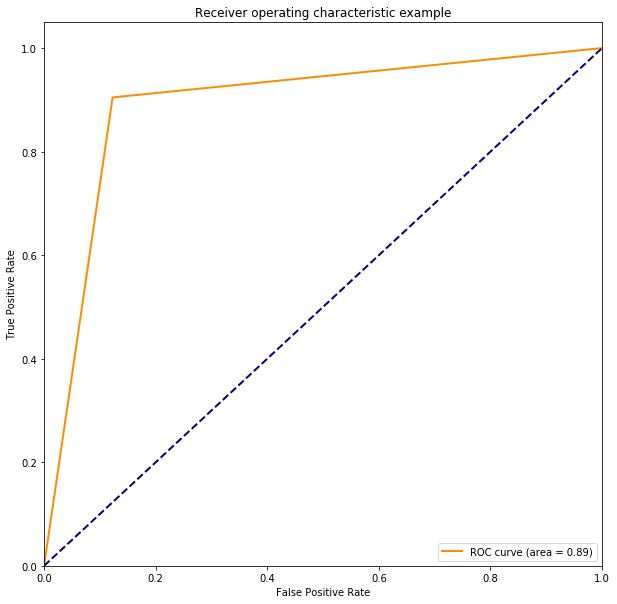

In [17]:
plot_ROC_CURVE(y_train, y_train_pred)
#plt.savefig('ROC.jpg', dpi = 300)
plt.show()

8. Plot **Confusion Matrix**.

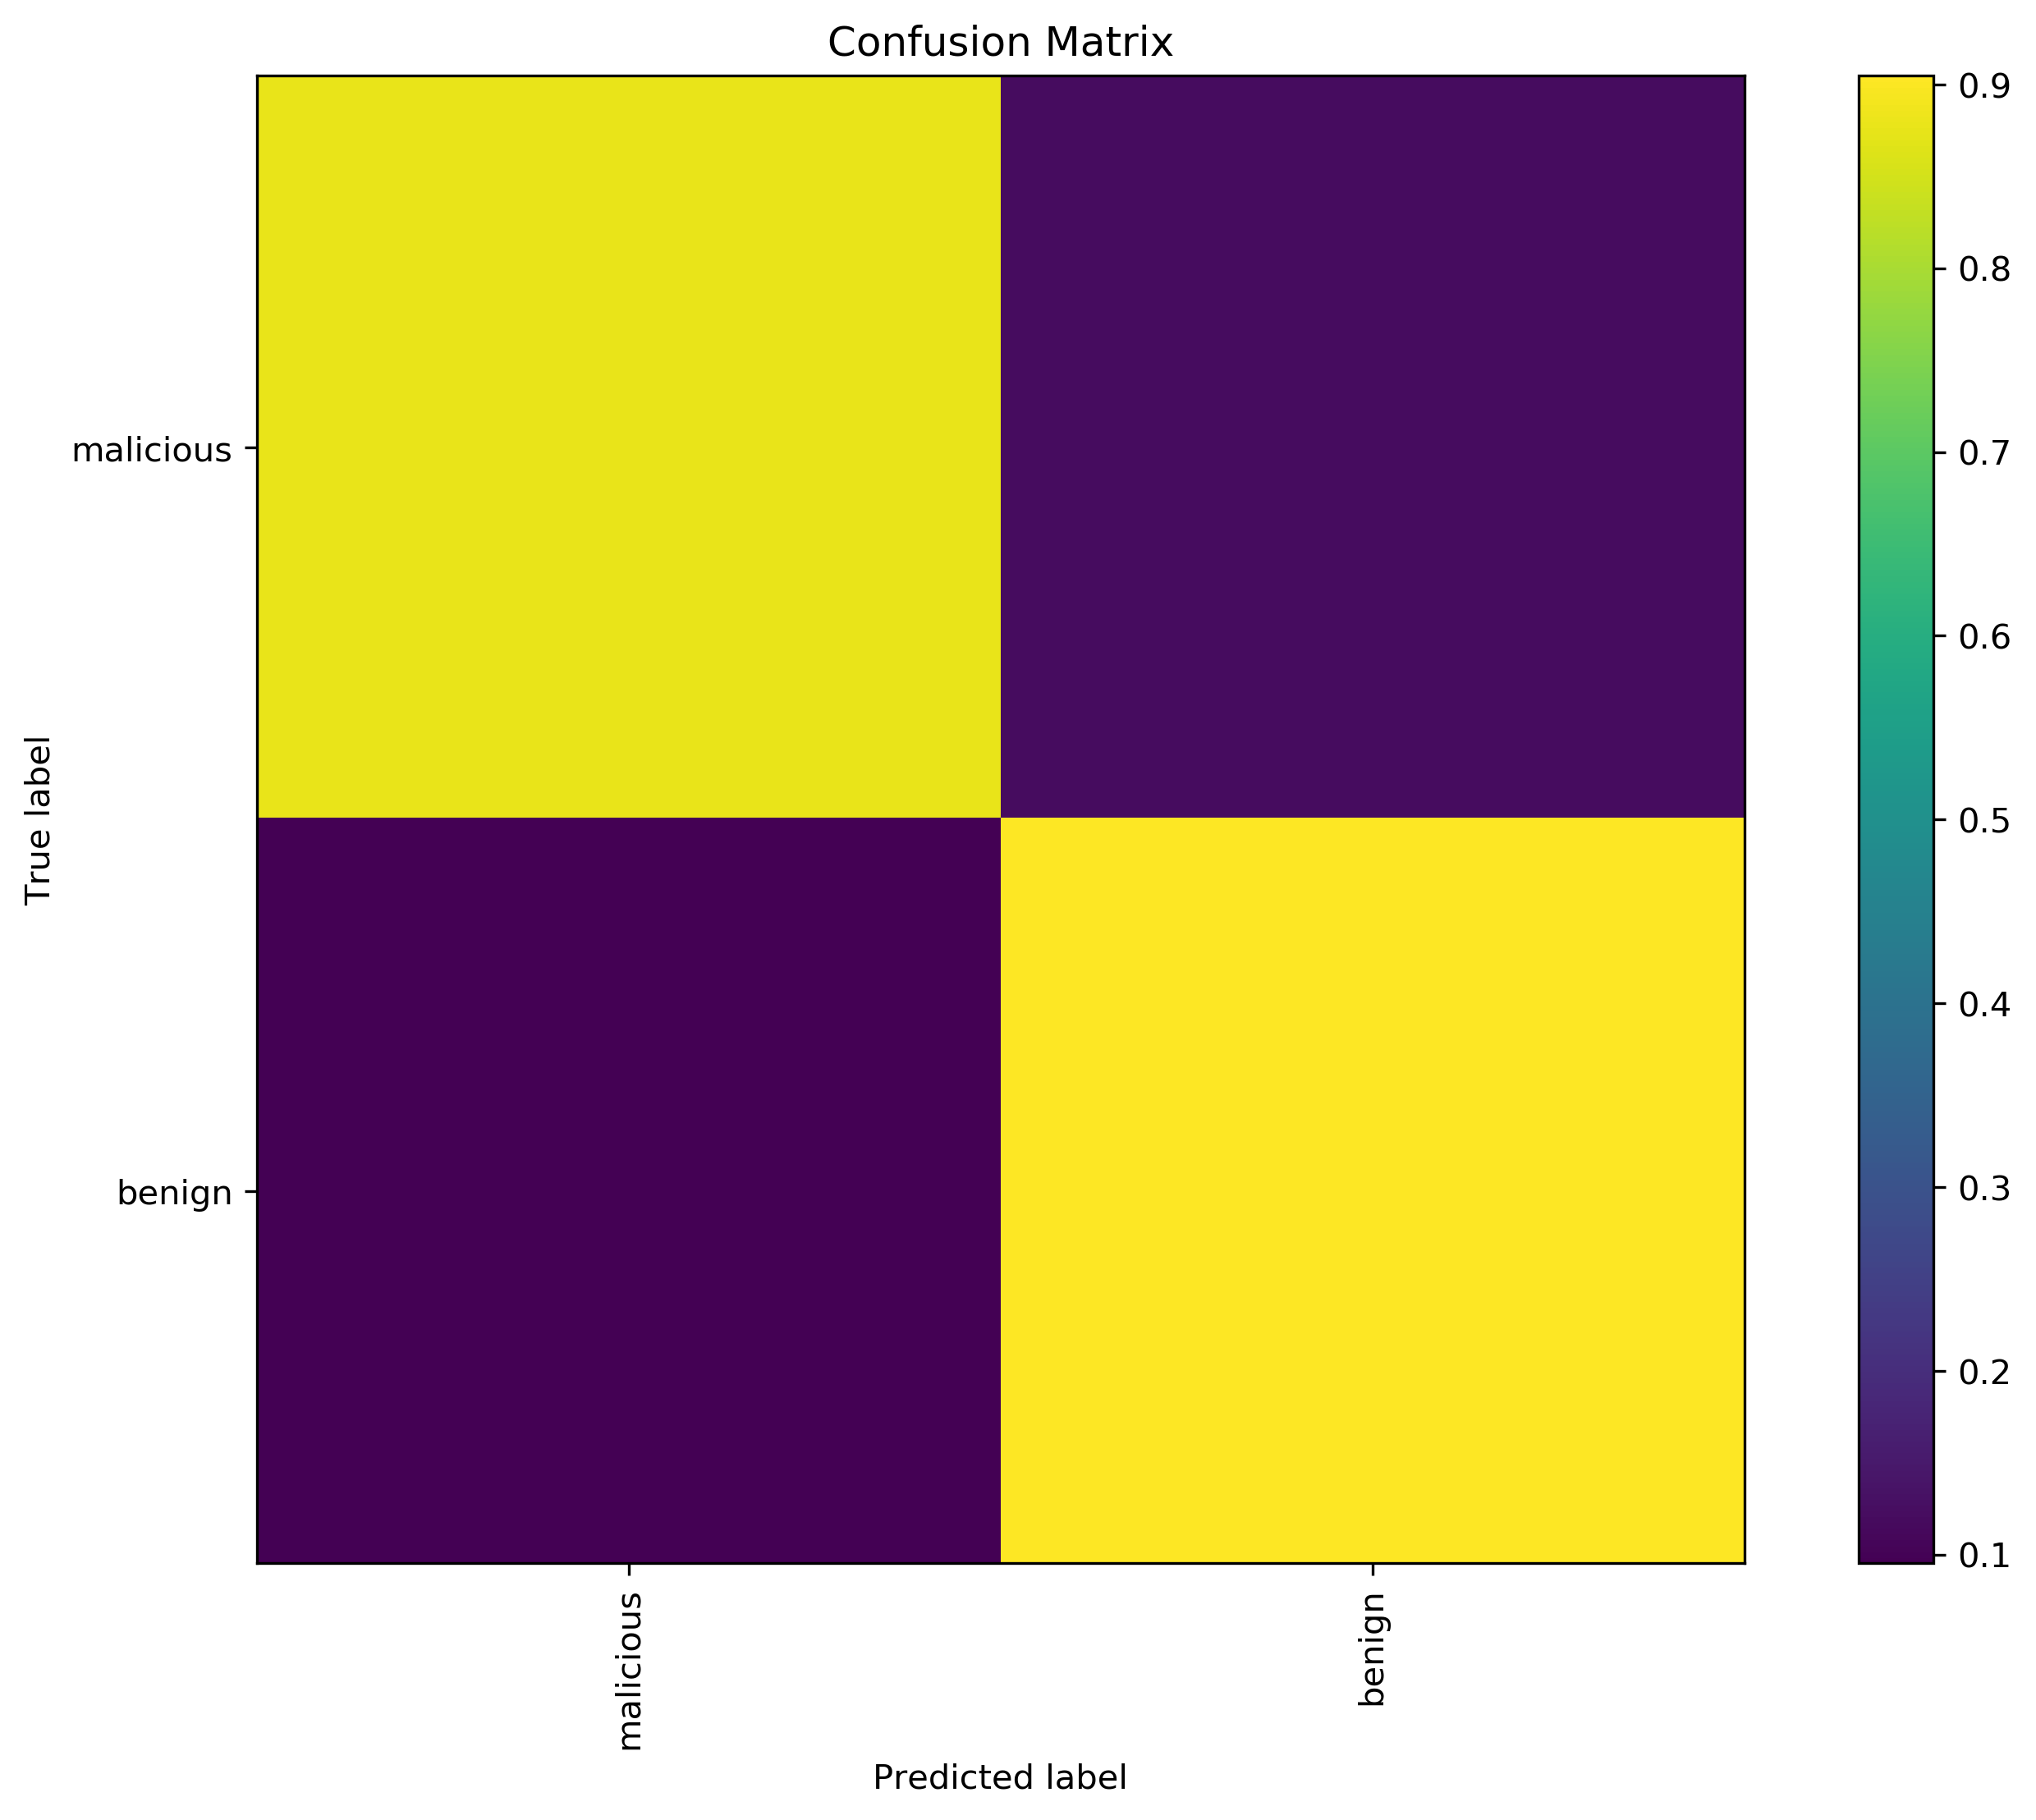

In [16]:
cm=confusion_matrix(y_train,y_train_pred)
plot_confusion_matrix(cm,["malicious","benign"],"Confusion Matrix")
#plt.savefig('confusion_matrix.jpg', dpi = 300)
plt.show()

9. Plot the **explained variance of component**.

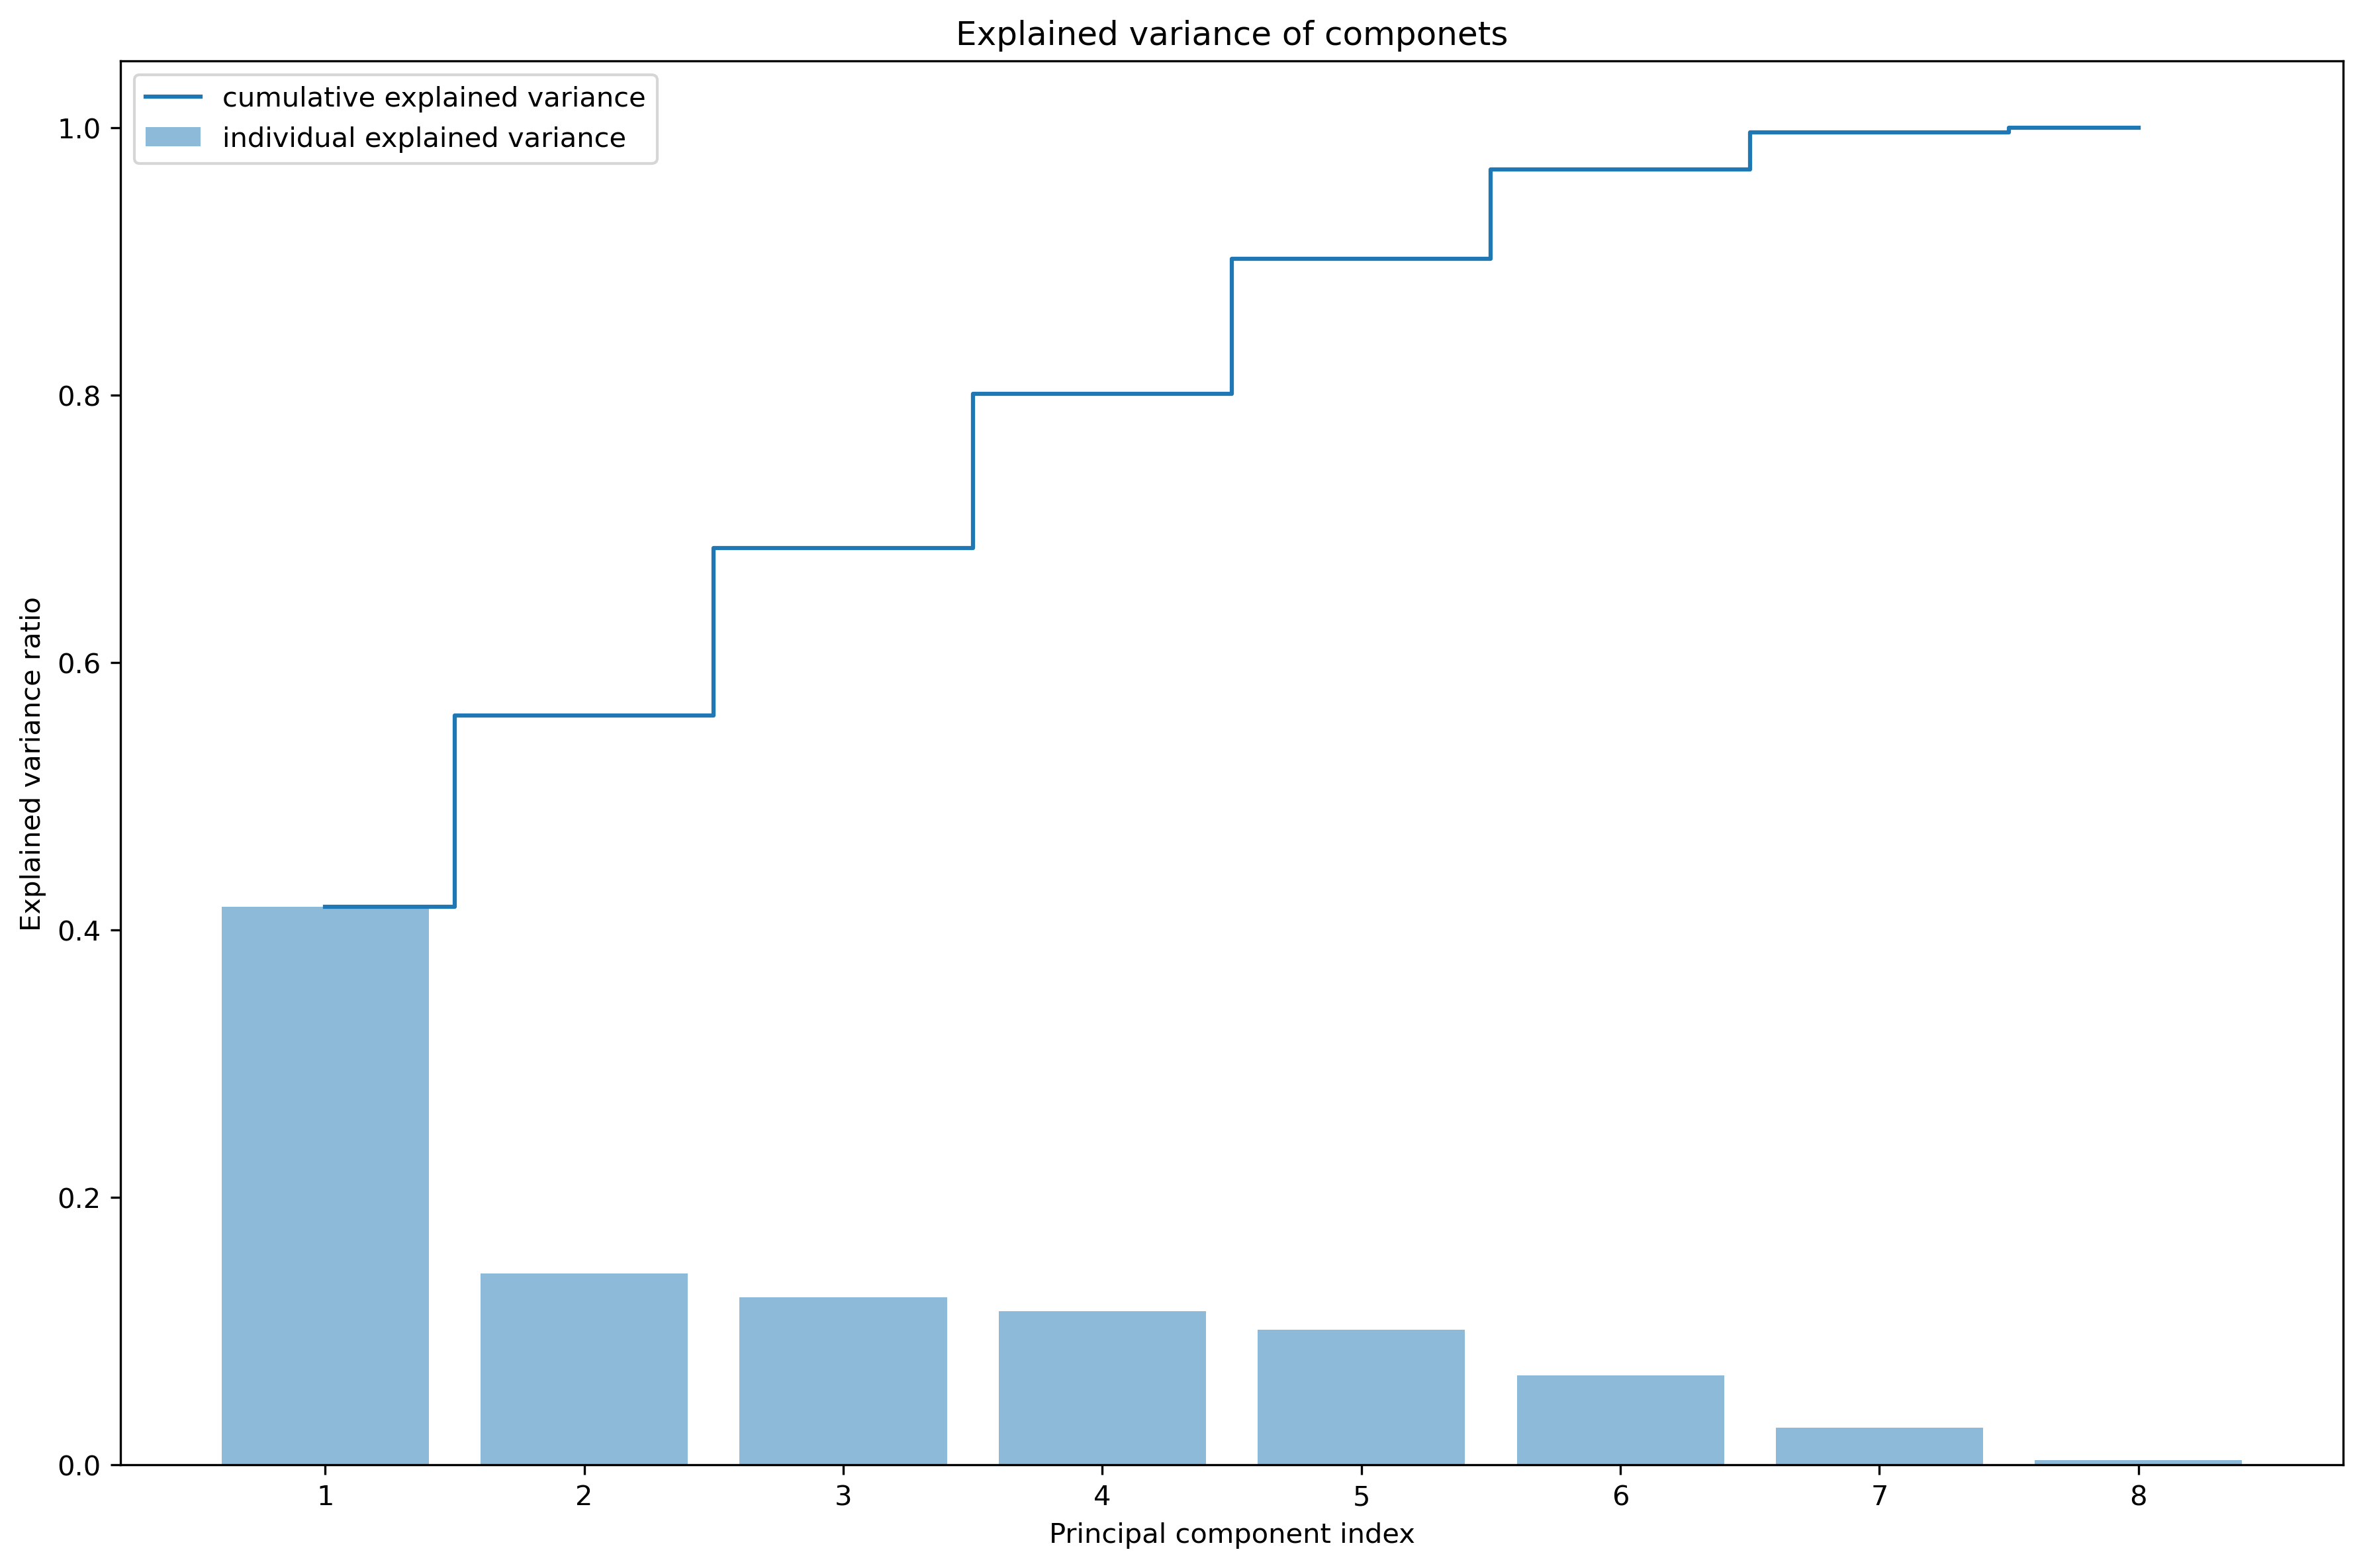

In [14]:
# Plot the explained variance of components
plot_pca(X_train_std)
plt.tight_layout()
# plt.savefig('explained_variance.png', dpi = 300)
plt.show()

10. Plot **learning curve**.

In [25]:
get_learning_curve(X_train, y_train)
# plt.savefig('learning_curve.jpg', dpi = 300)
plt.show()

KeyboardInterrupt: 

In [ ]:
# Save the configuration of the classifier and features as a pickle file.

all_features = X.shape[1]
features = []

for feature in range(all_features):
    features.append(df.columns[1+feature])

try:
    print("Saving algorithm and feature list in classifier directory...")
    joblib.dump(CV_clf, 'classifier.pkl')
    open('features.pkl', 'wb').write(pickle.dumps(features))
    print(colored('\n[*] ', 'green') + " Saved.")
except:
    print('\n Error: Algorithm and feature list not saved correctly.\n')

## Using the model above to identify  whether the url  is malicious

 - **get_url_info** function extracts features from a user supplied.The function extracts all features similarly to extract_features(),but instead saves the extracted features in the form of a dictionary. 

In [2]:
# Get URL information function extracts features from a user supplied
# URL. The function extracts all features similarly to extract_features()
# but instead saves the extracted features in the form of a dictionary. 
def get_url_info(url):
    # Creates a dictionary for features to be stored in.
    features = {}
    
    # Parses input URL to remove http:// or https://.
    parsed_url = parse_url(url)
    # Retrieve URL entropy and store in dictionary.
    feature = URLFeatures(parsed_url)
    entropy = feature.Entropy()
    features['Entropy'] = entropy


    # Store Bag Of Words in dictionary.  
    features['BagOfWords'] = feature.bag_of_words()
    
    # Store Contains IP address in dictionary.
    features['ContainsIP'] = feature.contains_IP()

    # Store URL length in dictionary.
    features['LengthURL'] = feature.url_length()

    # Store amount of special characters in dictionary.
    features['SpecialChars'] = feature.special_chars()

    # Store amount of suspicious strings in dictionary.
    features['SuspiciousStrings'] = feature.suspicious_strings()

    # Store number of digits within the URL in dictionary.
    features['NumberOfDigits'] = feature.num_digits()

    # Store site popularity in dictionary.
    features['Popularity'] = feature.popularity()

    # Store Google Safebrowsing verdict in dictionary.
    #apikey = base64.b64decode('QUl6YVN5QV9XbU53MHRyZTEybWtMOE1qYUExY0c3Smd4SnRuU0lv')
    #apikey = apikey.decode('utf-8')
    #safe = SafeBrowse(apikey)
    #features['Safebrowsing'] = safe.threat_matches_find(url) 

    # Return features dictionary.
    return features

- **classify_url** function passes in the input URL and classifies it as malicious or benign. 

In [3]:
def classify_url(url):

    # Loads classifier and feature configurations.
    clf = joblib.load(os.path.join(os.path.dirname(os.path.realpath(__file__)),'classifier.pkl'))

    features = pickle.loads(open(os.path.join(
        os.path.dirname(os.path.realpath(__file__)),
        'features.pkl'),
        'rb').read())
    
    # Extracts features from input URL.
    data = get_url_info(url)
    feature_list = list(map(lambda x:data[x], features))

    # Classifies input URL as malicious or benign.
    result = clf.predict([feature_list])[0]

    if result == 0:
        print("MLURL has classified URL %s as " % url + colored("benign", 'green') + '.')
    else: 
        print("MLURL has classified URL %s as " % url + colored("malicious", 'red') + '.')
    
    return result

- **check_valid_url** function checks whether or not the input URL to classify is in a valid format.


In [4]:
# Check valid URL function checks whether or not the input
# URL to classify is in a valid format.

def check_valid_url(url):
    print("\n[+] Validating URL format...")
    reg = re.compile('^(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?$')
    
    if re.match(reg, str(url)):
        print("URL is valid.")
    else:
        print("Error: URL is not valid. Please input a valid URL format. ")
        sys.exit(0)

In [5]:
top_website= pd.read_csv('top1m_rank.csv', delimiter='|', usecols = ['URL'], squeeze = True)

In [6]:
check_valid_url('weather.microsoft.com')
get_url_info('weather.microsoft.com')


[+] Validating URL format...
URL is valid.


{'Entropy': 3.5944656369614525,
 'BagOfWords': 3,
 'ContainsIP': 0,
 'LengthURL': 21,
 'SpecialChars': 0,
 'SuspiciousStrings': 0,
 'NumberOfDigits': 0,
 'Popularity': 1}

In [36]:
top_website.values

array(['google.com', 'netflix.com', 'api-global.netflix.com', ...,
       'api.hubblecontacts.com', 'api.huddle.net.dna.cdngd.net',
       'api.i.yiche.com'], dtype=object)